# This notebook analyse monsoon variables. 

In [2]:
'''Import packages for loading data, analysing, and plotting'''

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xesmf as xe
%matplotlib inline
import cartopy
import cartopy.crs as ccrs
import matplotlib
from netCDF4 import Dataset
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy.ma as ma
import math
import xlrd
import os
import matplotlib.colors as colors
import seaborn as sns
import scipy

In [3]:
#Define monsoon names
monsoonlist=['NAMS','NAF','SAS','EAS','SAMS','SAF','AUSMC']
#NAMS:North American Monsoon System
#NAF: North Africa
#SAS Southern Asia 
#EAS: East Asia Summer 
#SAMS: South America Monsoon System
#SAF: Southern Asia
#AUSMC: Aurtralian-Maritime Continent

In [4]:
#model namelist

pmip_v3='PMIP3'
pmip_v4='PMIP4'
pmip={}
pmip['PMIP4']=['AWI-ESM-1-1-LR',
               'CESM2',
               'EC-EARTH-3-3',
               'FGOALS-f3-L',
               'FGOALS-g3',
               'GISS-E2-1-G',
               'HadGEM3-GC31',
               'IPSL-CM6A-LR',
               'MIROC-ES2L',
               'MPI-ESM1-2-LR',
               'MRI-ESM2-0',
               'NESM3',
               'NorESM1-F',
               'NorESM2',
               'UofT-CCSM-4']
pmip['PMIP3']=['BCC-CSM1-1',
               'CCSM4',
               'CNRM-CM5',
               'CSIRO-Mk3L-1-2',
               'CSIRO-Mk3-6-0',
               'EC-EARTH-2-2',
               'FGOALS-g2',
               'FGOALS-s2',
               'GISS-E2-R',
               'HadGEM2-CC',
               'HadGEM2-ES',
               'IPSL-CM5A-LR',
               'KCM1-2-2',
               'MIROC-ESM',
               'MPI-ESM-P',
               'MRI-CGCM3']
               
               
               
  





In [5]:
#No change needs here

'''Define calculating functions, same as in Ensemble one with slight changes applied to fit monsoon calculations'''

#This function will get all available experiment names
def experimentlist():
    exps=[]
    file_path = "../DATA" 
    for dirpaths, dirnames, filenames in os.walk(file_path):
        for d in dirnames:
            exps.append(d)
    return exps

#This function will get all available model names in the experiment 
def modellist(experiment_name):
    models=[]
    file_path = "../DATA/%s" %(experiment_name)
    for dirpaths, dirnames, filenames in os.walk(file_path):
        for f in filenames:
            mname=f.split("_")[0]
            models.append(mname)
    return models

#This function will get all available filenames in the experiment 
def filenamelist(experiment_name):
    filenames=[]
    file_path = "../DATA/%s" %(experiment_name)
    for dirpaths, dirnames, files in os.walk(file_path):
        for f in files:
            ff='../DATA/%s/%s'%(experiment_name,f)
            filenames.append(ff)
    return filenames


def identify_ensemble_members(variable_name,experiment_name):
    datadir="../DATA/%s" %(experiment_name)
    ensemble_members=!scripts/find_experiment_ensemble_members.bash {experiment_name} {variable_name} {datadir}
    return ensemble_members

def extract_model_name(filename):
    file_no_path=filename.rpartition("/")
    file_strings=file_no_path[2].partition("_")
    model_name=file_strings[0]
    return model_name

def ensemble_members_dict(variable_name,experiment_name):
    ens_mems=identify_ensemble_members(variable_name,experiment_name)
    ens_mems_dict={extract_model_name(ens_mems[0]):ens_mems[0]}
    for mem in ens_mems[1:]:
        ens_mems_dict[extract_model_name(mem)]=mem
    return ens_mems_dict
    


In [13]:
#This function claculates monsoon domains
#summer rainrate - winter rainrate > 2.0
#summer rainrate/annual rainrate > 0.55
def monsoon_mean(pmip_v,expt):
    experiment_name=expt
    variable_name='monsoon_intensity' #summer rainrate - winter rainrate
    summerrain='monsoon_summer_rainrate'
    annualrain='pr_spatialmean_ann' #annual rainrate
    model_list=[]
    n=0
    average=0
    avesummer=0
    aveann=0
    grid_1x1= xr.Dataset({'lat': (['lat'], np.arange(-89.5, 90., 1.0)),
                         'lon': (['lon'], np.arange(0, 360, 1.0))})
    gcm_dict=ensemble_members_dict(variable_name,experiment_name)
    for gcm in gcm_dict:
        if gcm in pmip[pmip_v]:
            model_list.append(gcm)
            this_file=xr.open_dataset(gcm_dict.get(gcm),decode_times=False)
            ir=this_file[variable_name]
            sr=this_file[summerrain]
            ar=this_file[annualrain]
            this_regridder=xe.Regridder(this_file,grid_1x1,'bilinear', reuse_weights=True,periodic=True) 
            ir_1x1=this_regridder(ir)
            sr_1x1=this_regridder(sr)
            ar_1x1=this_regridder(ar)
            average=(n*average+ir_1x1)/(n+1)
            avesummer=(n*avesummer+sr_1x1)/(n+1)
            aveann=(n*aveann+ar_1x1)/(n+1)
            n=n+1
    ratio=avesummer/aveann
    m1=average >2.0
    m2=ratio >0.55
    mask=np.all([m1,m2],axis=0)
    aaa=avesummer.where(mask)
    ensemble_ave_r=np.zeros((180,360))
    for r in range(180):
        for c in range(360):
            ensemble_ave_r[:,c]=aaa[:,c-180] 
    return ensemble_ave_r

#This function defind the boundary of present monsoon domians from observation
def domain_obs():
    obs_file=xr.open_dataset('../DATA/C20-Reanalysis.cvdp_data.1871-2012.nc',decode_times=False)
    domain=obs_file['monsoon_domain']
    grid_1x1= xr.Dataset({'lat': (['lat'], np.arange(-89.5, 90., 1.0)),
                             'lon': (['lon'], np.arange(0, 360, 1.0))})
    this_regridder=xe.Regridder(obs_file,grid_1x1,'bilinear', reuse_weights=True,periodic=True) 
    obs_domain=this_regridder(domain)
    domain_r=np.zeros((180,360))
    for r in range(180):
        for c in range(360):
            domain_r[:,c]=obs_domain[:,c-180]
    ax=pd.DataFrame(domain_r)
    DO=np.array(ax.fillna(3000))
    return DO

In [42]:
#This function defind the boundary of midHolocene monsoon domians
    df=pd.DataFrame(GMD_mh)
    ccc=np.array(df.fillna(3000))
    return ccc

#This functions calculates the changes in monsoon intensity and summer rainrate (midHolocene - piControl)
def monsoon_mean_diffence(variable_name):
    model_list=[]
    n=0
    average=0
    A_dict=ensemble_members_dict(variable_name,'midHolocene')
    B_dict=ensemble_members_dict(variable_name,'piControl')
    grid_1x1= xr.Dataset({'lat': (['lat'], np.arange(-89.5, 90., 1.0)),
                         'lon': (['lon'], np.arange(0, 360., 1.0))})
    for gcm in A_dict:
        if gcm in B_dict:
            if gcm in pmip[pmip_v]:
                model_list.append(gcm)
                expt_a_file=xr.open_dataset(A_dict.get(gcm),decode_times=False)
                expt_a=expt_a_file[variable_name]
                expt_b_file=xr.open_dataset(B_dict.get(gcm),decode_times=False)
                expt_b=expt_b_file[variable_name]
                diff=expt_a-expt_b
                this_regridder=xe.Regridder(expt_a_file,grid_1x1,'bilinear', reuse_weights=True,periodic=True) 
                diff_1x1=this_regridder(diff)
                average=(n*average+diff_1x1)/(n+1)
                n=n+1
    ensemble_diff_r=np.zeros((180,360))
    for c in range(360):
        ensemble_diff_r[:,c]=average[:,c-180]
    return ensemble_diff_r

In [64]:
'''Define plotting function'''

y= np.arange(-89.5, 90., 1.0)
x=np.arange(-180, 180., 1.0)


def domian_plot(data,experiment_name):
    cmap=plt.get_cmap('GnBu')
    bounds = np.linspace(2, 16, 8)
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
    plt.figure(figsize=(18,10))
    title='%s' %(experiment_name)
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.0, globe=None))
    plt.title(title)
    ax.set_ylim([-40,60])
    ax.coastlines()
    ax.gridlines()
    fig=ax.contourf(x,y,data,levels=bounds, transform=ccrs.PlateCarree(),cmap=cmap,norm=norm)
    
    ax.contour(x,y,DO, levels=[100,110], colors='k', linestyles='-')
    cax,kw = matplotlib.colorbar.make_axes(ax,location='bottom',pad=0.05,shrink=0.7)
    plt.colorbar(fig,cax=cax,extend='both',**kw)
    
def domain_diff_plot(data,variable):
    cmap=plt.get_cmap('BrBG')
    clim=[-3,3]
    bounds = np.linspace(-3, 3, 11)
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
    plt.figure(figsize=(18,10))
    title='%s %s'%(chr(916),variable)
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.0, globe=None))
    plt.title(title)
    ax.set_ylim([-40,60])
    ax.coastlines()
    ax.gridlines()
    fig=ax.contourf(x,y,data, transform=ccrs.PlateCarree(),cmap=cmap,norm=norm,vmin=-8,vmax=8)
    fig.set_clim(-6,6)
    #ax.contour(x,y,DO, levels=[100,110], colors='k', linestyles='-')
    ax.contour(x,y,b_mh, levels=[100,110], colors='darkred', linestyles='-')
    ax.contour(x,y,b_pi, levels=[100,110], colors='darkblue', linestyles='-')
    cax,kw = matplotlib.colorbar.make_axes(ax,location='bottom',pad=0.05,shrink=0.7)
    plt.colorbar(fig,cax=cax,extend='both',**kw)
    

# Calculations -- PMIP4 Global monsoon domain


In [8]:
experiment_name='midHolocene'


In [11]:
# This section calculate global monsoon domain in midHolocene
GMD_mh=monsoon_mean(pmip_v4) 
DO=domain_obs()

Reuse existing file: bilinear_94x192_180x360_peri.nc


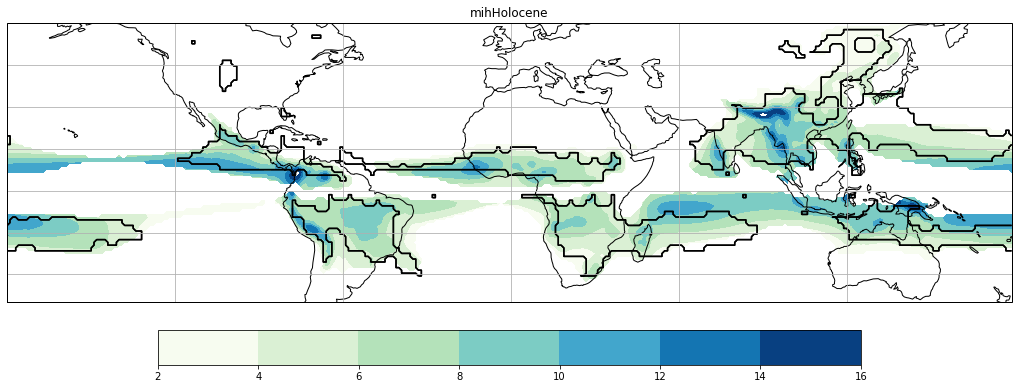

In [35]:
# Ensemble mean of PMIP4 midHolocene global monsoon domain
# Thick contour (black) shows observed domian in present-day 
domian_plot(GMD_mh,'mihHolocene')

In [14]:
# Same as above but for piControl

GMD_pi=monsoon_mean(pmip_v4,'piControl')

/Users/annie/anaconda3/envs/an/lib/python3.7/site-packages/xarray/conventions.py:448: SerializationWarning: variable 'nino34_autocorrelation' has multiple fill values {-1073741800.0, 1e+30}, decoding all values to NaN.
  stack_char_dim=stack_char_dim, use_cftime=use_cftime)


Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_180x288_180x360_peri.nc
Reuse existing file: bilinear_80x180_180x360_peri.nc
Reuse existing file: bilinear_90x144_180x360_peri.nc
Reuse existing file: bilinear_144x192_180x360_peri.nc
Reuse existing file: bilinear_143x144_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_96x144_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc


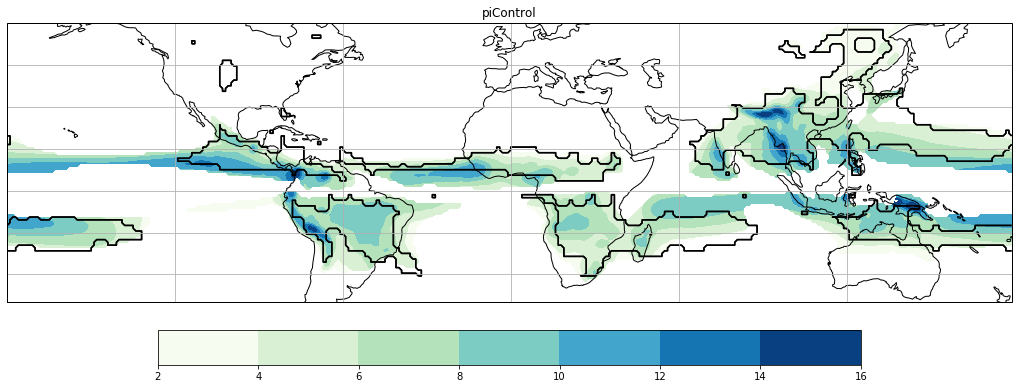

In [36]:
# Ensemble mean of PMIP4 piControl global monsoon domain
# Thick contour (black) shows observed domian in present-day 
domian_plot(GMD_pi,'piControl')

In [48]:
b_mh=monsoon_mean_boundary(GMD_mh)
b_pi=monsoon_mean_boundary(GMD_pi)

In [51]:
pmip_v='PMIP4'
sdiff=monsoon_mean_diffence('monsoon_summer_rainrate')
idiff=monsoon_mean_diffence('monsoon_intensity')

Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_180x288_180x360_peri.nc
Reuse existing file: bilinear_80x180_180x360_peri.nc
Reuse existing file: bilinear_90x144_180x360_peri.nc
Reuse existing file: bilinear_144x192_180x360_peri.nc
Reuse existing file: bilinear_143x144_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_96x144_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_180x288_180x360_peri.nc
Reuse existing file: bilinear_80x180_180x360_peri.nc
Reuse existing file: bilinear_90x144_180x360_peri.nc
Reuse existing file: bilinear_144x192_180x360_peri.nc
Reuse existing file: bilinear_143x144

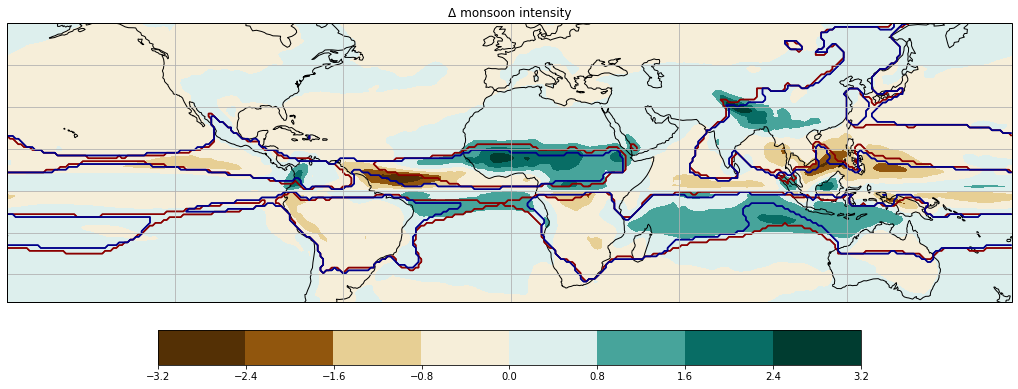

In [70]:
domain_diff_plot(idiff,'monsoon intensity')

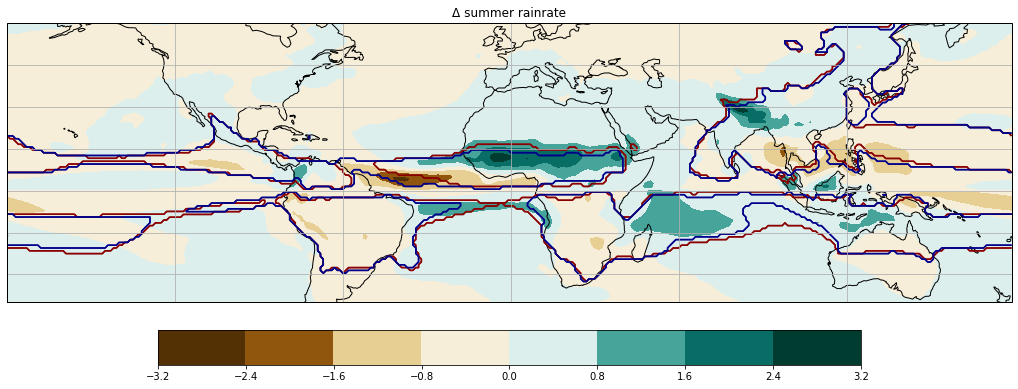

In [66]:
domain_diff_plot(sdiff,'summer rainrate')

# Making the monsoon domain figure for midHolocene paper

<Figure size 1296x720 with 0 Axes>

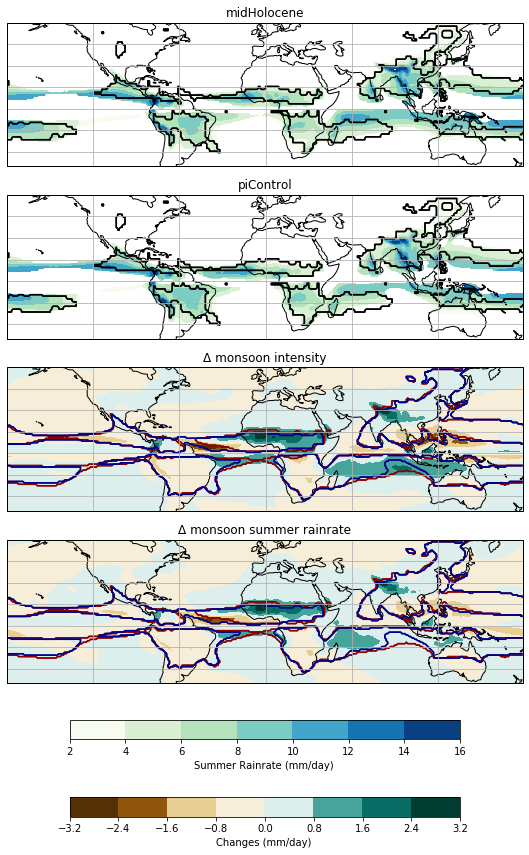

In [4]:
y= np.arange(-89.5, 90., 1.0)
x=np.arange(-180, 180., 1.0)



cmap1=plt.get_cmap('GnBu')
bounds1 = np.linspace(2, 16, 8)
norm1 = colors.BoundaryNorm(boundaries=bounds1, ncolors=256)
cmap2=plt.get_cmap('BrBG')
clim2=[-3,3]
bounds2 = np.linspace(-3, 3, 11)
norm2 = colors.BoundaryNorm(boundaries=bounds2, ncolors=256)



plt.figure(figsize=(18,10))
fig, axs = plt.subplots(nrows=4,ncols=1,figsize=(10,15),subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0.0, globe=None)})
ax1=axs[0]
ax2=axs[1]
ax3=axs[2]
ax4=axs[3]

ax1.set_title('midHolocene')
ax1.set_ylim([-40,60])
ax1.coastlines()
ax1.gridlines()
fig1=ax1.contourf(x,y,GMD_mh,levels=bounds1, transform=ccrs.PlateCarree(),cmap=cmap1,norm=norm1)
ax1.contour(x,y,DO, levels=[100,110], colors='k', linestyles='-')


ax2.set_title('piControl')
ax2.set_ylim([-40,60])
ax2.coastlines()
ax2.gridlines()
fig2=ax2.contourf(x,y,GMD_pi,levels=bounds1, transform=ccrs.PlateCarree(),cmap=cmap1,norm=norm1)
ax2.contour(x,y,DO, levels=[100,110], colors='k', linestyles='-')

title3='%s monsoon intensity'%(chr(916))

ax3.set_title(title3)
ax3.set_ylim([-40,60])
ax3.coastlines()
ax3.gridlines()
fig3=ax3.contourf(x,y,idiff, transform=ccrs.PlateCarree(),cmap=cmap2,norm=norm2)

#ax.contour(x,y,DO, levels=[100,110], colors='k', linestyles='-')
ax3.contour(x,y,b_mh, levels=[100,110], colors='darkred', linestyles='-')
ax3.contour(x,y,b_pi, levels=[100,110], colors='darkblue', linestyles='-')


title4='%s monsoon summer rainrate'%(chr(916))

ax4.set_title(title4)
ax4.set_ylim([-40,60])
ax4.coastlines()
ax4.gridlines()
fig4=ax4.contourf(x,y,sdiff, transform=ccrs.PlateCarree(),cmap=cmap2,norm=norm2)

#ax.contour(x,y,DO, levels=[100,110], colors='k', linestyles='-')
ax4.contour(x,y,b_mh, levels=[100,110], colors='darkred', linestyles='-')
ax4.contour(x,y,b_pi, levels=[100,110], colors='darkblue', linestyles='-')

cax2,kw2 = matplotlib.colorbar.make_axes([ax for ax in axs.flat],location='bottom',pad=0.05,shrink=0.7,fraction=0.05)
cb2=plt.colorbar(fig4, cax=cax2, **kw2,extend='max')
cax1,kw1 = matplotlib.colorbar.make_axes([ax for ax in axs.flat],location='bottom',pad=0.05,shrink=0.7,fraction=0.05)
cb1=plt.colorbar(fig1, cax=cax1, **kw1,extend='both')

cb1label='Summer Rainrate (mm/day) '
cb2label='Changes (mm/day) '
cb1.set_label(cb1label)
cb2.set_label(cb2label)